# Learning about Kalman filter / Extended Kalman Filter Part 3

**Resources**

`Kalman Filter from Ground Up`; author Alex Becker; https://www.kalmanfilter.net

**Overview**

A worked example of object tracking with the `EKF`-filter.

This notebook reproduces example 12 of chapter 13.8 `estimating the pendulum angle` with some additional annotations.

The figure below is copied from the book.

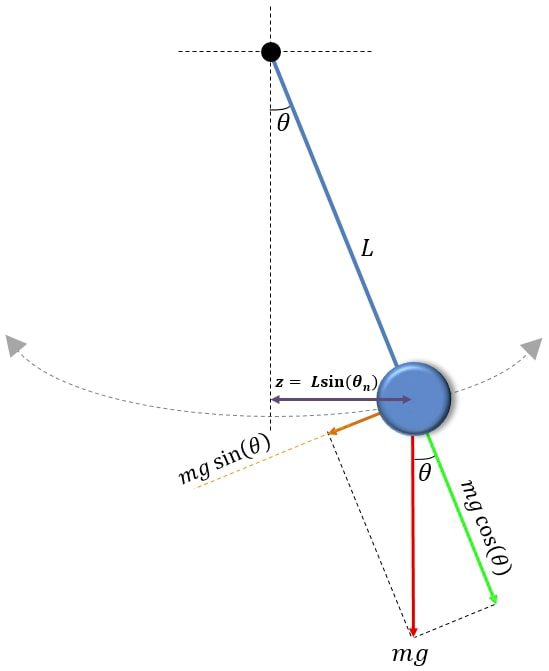



---

We now set up the equations of an extended Kalman filter (`EKF`) and to estimate the angle and its derivative .

For the state vector $\mathbf{x}_n$ we have:

$$
\mathbf{x}_n = \left[\begin{array}{c}
\theta_n \\ \dot{\theta}_n 
\end{array}\right]
$$

**note**

We do not develop the motion equations here. We just take the equations from the book.

**State extrapolation**

$$
\mathbf{\hat{x}}_{n+1,n} = \mathbf{f(\mathbf{\hat{x}}_{n,n})}
$$

$$
\mathbf{\hat{x}}_{n+1,n} = \left[\begin{array}{c}
\hat{\theta}_{n+1,n} \\ \hat{\dot{\theta}}_{n+1,n}
\end{array}\right] = \mathbf{f(\mathbf{\hat{x}}_{n,n})} = \left[\begin{array}{cc}
\hat{\theta}_{n,n} + \hat{\dot{\theta}}_{n,n} \cdot \Delta t \\
\hat{\dot{\theta}}_{n,n} - \frac{g}{L} \cdot sin(\hat{\theta}_{n,n}) \cdot \Delta t
\end{array}\right] = \left[\begin{array}{c}
f_1(\hat{\theta}_{n,n},\ \hat{\dot{\theta}}_{n,n}) \\
f_2(\hat{\theta}_{n,n},\ \hat{\dot{\theta}}_{n,n})
\end{array}\right]
$$

The state update equation has nonlinear terms. Hence we need to calculate the `Jacobian`-matrix.

$$
\frac{\partial f (\mathbf{\hat{x}}_{n,n})}{\partial \mathbf{x}}= \left[\begin{array}{cc}
\frac{\partial f_1(\hat{\theta}_{n,n},\ \hat{\dot{\theta}}_{n,n})}{\partial \hat{\theta}_{n,n}} & \frac{\partial f_1(\hat{\theta}_{n,n},\ \hat{\dot{\theta}}_{n,n})}{\partial \hat{\dot{\theta}}_{n,n}}   \\
\frac{\partial f_2(\hat{\theta}_{n,n},\ \hat{\dot{\theta}}_{n,n})}{\partial \hat{\theta}_{n,n}} & \frac{\partial f_2(\hat{\theta}_{n,n},\ \hat{\dot{\theta}}_{n,n})}{\partial \hat{\dot{\theta}}_{n,n}}
\end{array}\right] = \left[\begin{array}{cc}
1 & \Delta t \\
- \frac{g}{L} \cdot cos(\hat{\theta}_{n,n}) \cdot \Delta t & 1 
\end{array}\right]
$$


**covariance extrapolation**

$$
\mathbf{P}_{n+1,n} = \frac{\partial f (\mathbf{\hat{x}}_{n,n})}{\partial \mathbf{x}} \cdot \mathbf{P}_{n,n} \cdot \frac{\partial f (\mathbf{\hat{x}}_{n,n})}{\partial \mathbf{x}}^T + \mathbf{Q}
$$

The book gives a formula for the process noise which I cannot verify (some more work needed). 

$$
\mathbf{Q} = \left[\begin{array}{cc}
0.25 \cdot \Delta t^4  & 0.5 \cdot \Delta t^3 \\
0.5 \cdot \Delta t^3 & \Delta t^2
\end{array}\right] \cdot \sigma_a^2
$$

**measurement equation**

The x-position of the pendulum is measured. We have $x_n = L \cdot sin(\theta_n)$. The measurement is related to state variable $\theta_n$ via a nonlinear function. Hence we need the Jacobian matrix.

$$
x_n = L \cdot sin(\theta_n) = h(\mathbf{\hat{x}}_{n,n})
$$ 

$$
\frac{\partial h (\mathbf{\hat{x}}_{n,n})}{\partial \mathbf{x}}= \left[\begin{array}{cc}
\frac{\partial h (\mathbf{\hat{x}}_{n,n})}{\partial \hat{\theta}_{n,n}} & \frac{\partial h (\mathbf{\hat{x}}_{n,n})}{\partial \hat{\dot{\theta}}_{n,n}}
\end{array}\right] = \left[\begin{array}{cc}
L \cdot cos(\hat{\theta}_{n,n}) & 0
\end{array}\right]
$$

**measurement uncertainty**

We assume that the x-position of the pendulum is normally distributed random variable with standard deviation $\sigma_x$.

$$
\mathbf{R} = \left[\begin{array}{c}
\sigma_x^2
\end{array}\right]
$$

**Kalman gain**

$$
\mathbf{K_n} = \mathbf{P}_{n,n-1} \cdot \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})} ^T \cdot \left( \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})}  \cdot \mathbf{P}_{n,n-1} \cdot \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})}^T + \mathbf{R}_n \right)^{-1}
$$ 

**State Update**

$$
\mathbf{\hat{x}_{n,n} } = \mathbf{\hat{x}_{n,n-1}} + \mathbf{K_n} \cdot \left(\mathbf{z_n} - h(\mathbf{\hat{x}_{n,n-1}})  \right)
$$

**Covariance Update**

$$
\mathbf{P_{n,n}} = \left(\mathbf{I} - \mathbf{K_n} \cdot \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})}  \right) \cdot \mathbf{P}_{n,n-1} \cdot \left(\mathbf{I} - \frac{\partial \mathbf{h(\hat{x}_{n,n-1})}}{\partial (\mathbf{x})} ^T \cdot \mathbf{K_n}^T  \right) + \mathbf{K_n} \cdot \mathbf{R}_n \cdot \mathbf{K_n}^T
$$

---

Below the computational steps of the book shall be reproduced (at least for the first iteration)

**parameters**

| parameter | value | description |
|-----------|-------|-------------|
| $L$ | 0.5 m | length of pendulum |
| $g$  | $9,8 \ [m/s^2]$ | gravitational acceleration |
| $\sigma_x$ | $0.01 \ m$ | meaurement uncertainty |
| $\sigma_a$ | $1 \ rad/s^2$ | angular acceleration uncertainty |



In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

# the first 10 positional measurements
x_vec = np.array([0.119, 0.113, 0.12, 0.101, 0.099, 0.063, 0.008, -0.017, -0.037, -0.05])

dt= 0.05
L = 0.5
g = 9.8
sigma_x = 0.01
sigma_a = 1.0

Q_mat = (sigma_a**2) * np.array([
    [0.25*(dt**4), 0.5*(dt**3)],
    [0.5*(dt**3), dt**2]
])

R_mat = sigma_x**2

# initialisation
theta_0 = 0.0873
v_theta_0 = 0.0

# initial state vector
x_00_vec = np.array([theta_0, v_theta_0])

# initial state covariance
P_00_mat = np.array([[5,0], [0,5]])

# prediction using the state extrapolation equation
x_10_vec = np.array([x_00_vec[0] + x_00_vec[1]*dt, x_00_vec[1] - (g/L)*math.sin(x_00_vec[0])*dt])

# Jacobian 1
J_f_mat = np.array([
    [1, dt],
    [-(g/L)*math.cos(x_00_vec[0])*dt, 1]
])

# uncertainty propgation
P_10_mat = J_f_mat @ P_00_mat @ J_f_mat.T + Q_mat

# print 
print(f"Q_mat:\n{Q_mat}\n")
print(f"x_00_vec:\n{x_00_vec}\n")
print(f"P_00_mat:\n{P_00_mat}\n")
print(f"x_10_vec:\n{x_10_vec}\n")
print(f"J_f_mat:\n{J_f_mat}\n")
print(f"P_10_mat:\n{P_10_mat}\n")

Q_mat:
[[1.5625e-06 6.2500e-05]
 [6.2500e-05 2.5000e-03]]

x_00_vec:
[0.0873 0.    ]

P_00_mat:
[[5 0]
 [0 5]]

x_10_vec:
[ 0.0873     -0.08544537]

J_f_mat:
[[ 1.          0.05      ]
 [-0.97626794  1.        ]]

P_10_mat:
[[ 5.01250156 -4.6312772 ]
 [-4.6312772   9.76799544]]



In [41]:
# 1st measurement
x_1 = x_vec[0]

# nonlinear observation output
x_o_1 = L * math.sin(x_10_vec[0])

# Jacobian of observation
J_h_mat = np.array([L *  math.cos(x_10_vec[0]), 0])

# Kalman gain
Aux_mat = P_10_mat @ J_h_mat.T
Inv_mat = 1.0/(np.dot(J_h_mat, Aux_mat)+ R_mat)
K_1_mat = Aux_mat * Inv_mat

# current state estimate
x_11_vec = x_10_vec + K_1_mat * (x_1 - x_o_1)

# covariance
# we cannot use K_1_mat @ J_h_mat since it would be a scalar and not a 2 by 2 matrix
# reason : K_1_mat and J_h_mat are both vectors; the @ operator cannot infer that K_1_mat is col vector and J_h_mat a row vector
Tmp_mat = np.eye(2) - np.outer(K_1_mat, J_h_mat)


P_11_mat = Tmp_mat @ P_10_mat @ Tmp_mat.T +  K_1_mat @ (R_mat * K_1_mat.T)

print(f"x_1 (measurement): {x_1}\n")
print(f"observation output: {x_o_1}\n")
print(f"J_h_mat:\n{J_h_mat} \n")
print(f"K_1_mat:\n{K_1_mat}\n")
print(f"x_11_vec:\n{x_11_vec}\n")
print(f"P_11_mat:\n{P_11_mat}\n")


x_1 (measurement): 0.119

observation output: 0.0435945762394938

J_h_mat:
[0.49809589 0.        ] 

K_1_mat:
[ 2.00748414 -1.85480551]

x_11_vec:
[ 0.23867519 -0.22530777]

P_11_mat:
[[7.47062012e-04 7.46999665e-04]
 [7.46999665e-04 5.48969576e+00]]



## Comments

The first iteration give results similar to those presented in

`Kalman Filter from Ground Up`; author Alex Becker; https://www.kalmanfilter.net

example 12 of chapter 13.8 `estimating the pendulum angle` 

The state description of the pendulum have been copied without further verification_

Reason: Currently I do not have the mathematical background ... but probably I will come back to this topic some time later.